# Análisis descriptivo

Imports


In [2]:
import pandas as pd

Carga de datos

In [3]:

path = r'C:\Users\ctrujils\order_detail_sorted_cluster.parquet'
order_detail_sorted= pd.read_parquet(path)

In [77]:
pd.options.display.float_format ='{:,.2f}'.format
order_detail_sorted.pivot_table(index='NameDistributor', columns='Origin', values='Sellout', aggfunc='sum')

Origin,OFFLINE,Online
NameDistributor,,
Bebicer,"5,439,529.71","25,611.15"
Ceres,"13,192,922.44",NaN
Voldis Baleares,NaN,"1,850,482.35"
Voldis Coruña,"9,283,093.66","843,816.33"
Voldis Granada,"27,248,345.83","2,458,670.21"
Voldis Madrid,"57,662,859.90","3,893,637.30"
Voldis Murcia,"221,970.85","1,170,011.37"
Voldis Valencia,"13,623,363.96","2,325,648.43"


In [4]:
maestro_cliente_path = r'C:\Users\ctrujils\maestro_clientes_12UM_cluster.parquet'
maestro_clientes = pd.read_parquet(maestro_cliente_path)

In [5]:
order_detail_sorted.shape

(689818, 24)

### Filtros aplicados

In [6]:
order_detail_sorted=order_detail_sorted[order_detail_sorted['Sellout']>0]

## Análisis general segmentación, sellout, cupones

Puntos de venta totales en muestra

In [7]:
order_detail_sorted['PointOfSaleId'].nunique()

20994

Puntos de venta por cluster

* Cluster -1 : clientes inactivos
* Cluster 0 :  clientes regulares
* Cluster 1 : clientes esporádicos
* Cluster 2 : clientes premiun
* No Clusterizado

In [8]:
maestro_clientes['Cluster']=maestro_clientes['Cluster'].fillna('No Cluster')
order_detail_sorted['Cluster']=order_detail_sorted['Cluster'].fillna('No Cluster')

In [9]:
pdv_por_cluster = maestro_clientes.groupby('Cluster').size().reset_index(name='Count')

pdv_por_cluster

,Cluster,Count
0,-1.0,1979
1,0.0,4545
2,1.0,5070
3,2.0,2286
4,No Cluster,9809


In [10]:
pdv_por_facturacion = maestro_clientes.groupby('abc').size().reset_index(name='Count')

pdv_por_facturacion

,abc,Count
0,A,2075
1,B,4153
2,C,6211
3,D,8156


OFFLINE/ONLINE

In [11]:
# Eliminar duplicados para quedarnos solo con una fila única por cada 'PointOfSaleId'
order_detail_sorted_unique= order_detail_sorted.drop_duplicates(subset='PointOfSaleId', keep='first')

# # Mostrar el resultado para confirmar que solo quedan los puntos de venta únicos
# print(f"Total de puntos de venta únicos: {order_detail_sorted_unique['PointOfSaleId'].nunique()}")


In [12]:

pdv_por_Origen= order_detail_sorted_unique.groupby('Origin').size().reset_index(name='Count')   ### CAMBIAR
pdv_por_Origen

,Origin,Count
0,OFFLINE,18108
1,Online,2886


In [66]:
sellout_origen = order_detail_sorted.groupby('Origin')['Sellout'].mean()
sellout_origen

Origin
OFFLINE    229.846088
Online     301.171271
Name: Sellout, dtype: float64

In [13]:
pdvs_por_cluster_origin = order_detail_sorted_unique.groupby(['Cluster', 'Origin'])['PointOfSaleId'].nunique().reset_index(name='Count')

# Mostrar el resultado
pdvs_por_cluster_origin   ### revisar

,Cluster,Origin,Count
0,-1.0,OFFLINE,1015
1,0.0,OFFLINE,3879
2,1.0,OFFLINE,2416
3,2.0,OFFLINE,2192
4,No Cluster,OFFLINE,8606
5,No Cluster,Online,2886


Sellout media € / cluster

In [14]:
# Agrupar por 'Cluster' y calcular la media de 'Sellout'
sellout_media_por_cluster = order_detail_sorted.groupby('Cluster')['Sellout'].mean().reset_index(name='Average_Sellout')

# Mostrar el resultado
sellout_media_por_cluster


,Cluster,Average_Sellout
0,-1.0,240.312034
1,0.0,139.354499
2,1.0,197.061014
3,2.0,343.188568
4,No Cluster,201.463906


Uso de Cupones/ Compras totales por Tipologia %

In [15]:
order_detail_sorted['CouponCode'].unique()

array([None, 'BIENVENIDA20', 'SEGUNDOPEDIDO15%', 'TERCERPEDIDO15E',
       'CUARTOPEDIDO10E', 'Bienvenida20', 'Segundopedido15%', 'Final10E',
       'Voldis15%', 'Mereces15', 'FINAL10E', 'MERECES15', 'VOLDIS15%',
       'HAPPY10', 'HISTORIAS10', 'Final10e', 'Mereces15 ',
       'BIENVENIDA20%7E', 'VOLDIS15E', 'CERVEZA15', 'BIENVENIDA20%PT',
       'VOLDIS10E', 'BiENVENIDA20', 'SANPATRICIO15', 'PASCUA15',
       'Primavera20', 'Verano15', 'Bar10', 'BAR10', 'REGRESO20',
       'CALABAZA20', 'PRIMAVERA20E', 'VOlDIS15%', 'Regreso20',
       'voldis15%', 'ene-10', 'CUPIDO20', 'Final10', 'VERANO15',
       'Cerveza15', 'Voldis15e', 'Happy10', 'Historias10',
       'REGALO20J7PD5', 'Calabaza20', 'FINAL10', 'REGALO20E2UWI',
       'FINAL10EG3SR', 'BAR10 ', 'REGRESO20 ', 'bienvenida20',
       'cerveza15', 'PRIMAVERA20', 'NAVIBAR20', 'bar10', 'voldis15E',
       'VUELVE10', 'AÑONUEVO15', 'voldis15e', 'CALABAZA20 ', 'Voldis15E',
       'VOLDIS15e', 'calabaza20', 'happy10', 'BAR10ZDN4QPD1L7N6',
 

In [16]:
order_detail_sorted['HasCoupon'] = order_detail_sorted.apply(
    lambda row: 1 if (row['CouponDiscountAmt'] > 0 or row['CouponDiscountPct'] > 0) else 0,
    axis=1
)


# Agrupar por 'Cluster' y calcular el promedio de 'HasCoupon' (esto nos dará el porcentaje de uso de cupones)
uso_cupones_por_cluster = order_detail_sorted.groupby('tipologia')['HasCoupon'].mean().reset_index(name='Coupon_Usage_Rate')

# Convertir a porcentaje
uso_cupones_por_cluster['Coupon_Usage_Rate'] = uso_cupones_por_cluster['Coupon_Usage_Rate'] * 100

# Mostrar el resultado
uso_cupones_por_cluster

,tipologia,Coupon_Usage_Rate
0,Bar Tradicional,14.091026
1,Cervecería,9.554347
2,Discoteca,8.251086
3,Establecimiento de Tapeo,9.295430
4,No Segmentado,0.310417
5,Noche Temprana,11.289564
6,Pastelería/Cafetería/Panadería,12.824343
7,Restaurante,9.914970
8,Restaurante de Imagen,5.338884
9,Restaurante de Imagen con Tapeo,6.039308


### Uso de cupon/compras totales

In [70]:
sales_coupon = order_detail_sorted[order_detail_sorted['HasCoupon'] == 1].groupby('PointOfSaleId')['Sellout'].sum()

# Calcular las ventas totales por PointOfSaleId
total_sales = order_detail_sorted.groupby('PointOfSaleId')['Sellout'].sum()

pctg_coupon_used = (sales_coupon / total_sales) * 100

pctg_coupon_used = pctg_coupon_used.reset_index(name='PctgCouponUsed')

# Rellenar los valores NaN con 0 para aquellos puntos de venta que no usaron cupones
pctg_coupon_used['PctgCouponUsed'].fillna(0, inplace=True)
pctg_coupon_used


C:\Users\ctrujils\AppData\Local\Temp\ipykernel_23228\2803478393.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pctg_coupon_used['PctgCouponUsed'].fillna(0, inplace=True)


,PointOfSaleId,PctgCouponUsed
0,00001,0.000000
1,00011,0.000000
2,00017,0.000000
3,00025,0.000000
4,00042,0.000000
...,...,...
20989,MS0787,100.000000
20990,c08599,37.499256
20991,c09165,100.000000
20992,c09210,14.658503


In [68]:
# Crear un diccionario para mapear 'PointOfSaleId' con 'PctgCouponUsed'
pctg_coupon_used_dict = pctg_coupon_used.set_index('PointOfSaleId')['PctgCouponUsed'].to_dict()

# Asignar el porcentaje de uso de cupones a cada 'PointOfSaleId' en order_detail_sorted usando .map()
order_detail_sorted['PctgCouponUsed'] = order_detail_sorted['PointOfSaleId'].map(pctg_coupon_used_dict)

PDVs con % de uso de cupones >60


In [19]:
# Definir el contador antes del bucle
contador = 0


for pdv_id, porcentaje in pctg_coupon_used_dict.items():
    
    try:
        porcentaje = float(porcentaje)
    except ValueError:
        continue  

    if porcentaje > 60.0:
        contador += 1
        # Imprimir el resultado, si es necesario
        print(f"PDV {pdv_id}: {porcentaje:.2f}% de uso de cupones en compras totales.")


print(f"Total de puntos de venta con más del 60% de uso de cupones: {contador}")


PDV 100005: 96.61% de uso de cupones en compras totales.
PDV 10012: 100.00% de uso de cupones en compras totales.
PDV 100131: 100.00% de uso de cupones en compras totales.
PDV 100141: 79.59% de uso de cupones en compras totales.
PDV 100150: 100.00% de uso de cupones en compras totales.
PDV 100152: 100.00% de uso de cupones en compras totales.
PDV 100154: 100.00% de uso de cupones en compras totales.
PDV 100182: 100.00% de uso de cupones en compras totales.
PDV 100185: 100.00% de uso de cupones en compras totales.
PDV 100190: 96.77% de uso de cupones en compras totales.
PDV 100232: 100.00% de uso de cupones en compras totales.
PDV 100252: 100.00% de uso de cupones en compras totales.
PDV 100275: 100.00% de uso de cupones en compras totales.
PDV 100336: 78.53% de uso de cupones en compras totales.
PDV 100341: 91.50% de uso de cupones en compras totales.
PDV 100349: 91.39% de uso de cupones en compras totales.
PDV 100353: 100.00% de uso de cupones en compras totales.
PDV 100357: 80.50% de

In [74]:
order_detail_sorted[order_detail_sorted['NameDistributor']=='Voldis Baleares']['Origin'].value_counts()

Origin
Online    7651
Name: count, dtype: int64

###Análisis cupones

Cupon máximo

In [20]:
order_detail_sorted['CouponDiscountAmt'] = pd.to_numeric(order_detail_sorted['CouponDiscountAmt'], errors='coerce').fillna(0)
kpis_por_pdv_promo = order_detail_sorted.groupby(['PointOfSaleId', 'CouponCode']).agg(
    impacto_promociones=pd.NamedAgg(column='CouponDiscountAmt', aggfunc='sum'), #impacto monetario por cupones aplicados por PDV
    # total_productos_comprados=pd.NamedAgg(column='Amount', aggfunc='sum') # total de la cantidad de productos comprados por cada PDV
).reset_index()

In [21]:
kpis_por_pdv_promo.sort_values('impacto_promociones',ascending=False).head(30)

,PointOfSaleId,CouponCode,impacto_promociones
4066,C05681,REGRESO20,399.670013
2889,81204,REGRESO20,356.899994
10007,CLI0026803,Regreso20,348.000000
4594,C08251,Regreso20,329.609985
9735,CLI0026381,REGRESO20,328.799988
5493,C10302,Regreso20,325.500000
12155,CLI0029258,Regreso20,260.000000
1176,102232,Mereces15,225.000000
10472,CLI0027298,REGRESO20,220.000000
16251,CLI0034240,REGRESO20,201.500000


-------------------------------------

Sellout medio por tipologia de cupon

In [67]:
sellout_promedio_por_cupon = order_detail_sorted.groupby('Coupon_type')['Sellout'].mean()
sellout_promedio_por_cupon

Coupon_type
Fijo          337.448869
NoCupon       230.870983
Porcentual    303.970800
Name: Sellout, dtype: float64

### PDVs dormidos en la plataforma


In [22]:
# order_detail_sorted=order_detail_sorted[order_detail_sorted['OrderDate']<'29-07-2024']

In [23]:
last_order_dates = order_detail_sorted.groupby(['PointOfSaleId', 'NameDistributor'])['OrderDate'].max().reset_index()
last_order_dates.columns = ['PointOfSaleId','NameDistributor', 'LastOrderDate']


In [24]:
online_orders = order_detail_sorted[order_detail_sorted['Origin'] == 'Online']
last_online_order_dates = online_orders.groupby(['PointOfSaleId', 'NameDistributor'])['OrderDate'].max().reset_index()
last_online_order_dates.columns = ['PointOfSaleId', 'NameDistributor', 'LastOnlineOrderDate']

In [25]:
last_order_dates_general = pd.merge(last_order_dates, last_online_order_dates, on=['PointOfSaleId',  'NameDistributor'], how='left')

In [26]:
last_order_dates_general['DaysBetweenLastOrderAndLastOnline'] = (last_order_dates_general['LastOrderDate'] - last_order_dates_general['LastOnlineOrderDate']).dt.days

In [27]:
last_order_dates_general=last_order_dates_general.dropna()

In [28]:
last_order_dates_general=last_order_dates_general.sort_values(by='DaysBetweenLastOrderAndLastOnline', ascending=False)

Aplico filtro de > 50 días entre compras considero dormido en la plataforma

In [29]:
last_orders_dates_general=last_order_dates_general[last_order_dates_general['DaysBetweenLastOrderAndLastOnline']>50]
last_orders_dates_general

,PointOfSaleId,NameDistributor,LastOrderDate,LastOnlineOrderDate,DaysBetweenLastOrderAndLastOnline
15651,CLI0037791,Voldis Valencia,2024-07-11,2023-01-04,554.0
15502,CLI0037573,Voldis Valencia,2024-07-10,2023-01-03,554.0
16133,CLI0038603,Voldis Valencia,2024-07-03,2023-01-03,547.0
17313,CLI0040998,Voldis Valencia,2024-06-26,2023-01-03,540.0
16124,CLI0038587,Voldis Valencia,2024-07-05,2023-01-12,540.0
...,...,...,...,...,...
11131,CLI0029281,Voldis Madrid,2024-05-30,2024-04-08,52.0
10609,CLI0027942,Voldis Granada,2024-07-11,2024-05-21,51.0
8495,CLI0024677,Voldis Granada,2024-07-10,2024-05-20,51.0
8606,CLI0024875,Voldis Granada,2023-11-08,2023-09-18,51.0


In [30]:
pdvs_unicos = last_orders_dates_general['PointOfSaleId'].unique()

lista_pdvs = pdvs_unicos.tolist()

In [31]:
df_filtered = order_detail_sorted[order_detail_sorted['PointOfSaleId'].isin(lista_pdvs)]

In [32]:
df_online = df_filtered[df_filtered['Origin'] == 'Online']
sellout_online = df_online['Sellout'].sum()

In [33]:
sellout_online_df = df_online.groupby('PointOfSaleId').agg({
    'Sellout': 'sum',
    'Code':'count'
}).reset_index()

In [34]:
grouped_df = df_filtered.groupby('PointOfSaleId').agg({
    'CouponDiscountAmt': 'sum',
}).reset_index()

In [35]:
merged_df = pd.merge(sellout_online_df, grouped_df, on='PointOfSaleId', how='left')


In [36]:
def filter_coupons(coupons):
    return [coupon for coupon in coupons if coupon is not None]

# Obtener cupones únicos usados por cada PDV y filtrar los None/NaN
df_filtered = df_filtered.groupby('PointOfSaleId')['CouponCode'].apply(lambda x: filter_coupons(x.unique())).reset_index()
df_filtered.columns = ['PointOfSaleId', 'UniqueCoupons']

# Calcular el número de cupones únicos por PDV excluyendo None/NaN
df_filtered['NumberOfUniqueCoupons'] = df_filtered['UniqueCoupons'].apply(len)


In [37]:
merged_df = pd.merge(df_filtered, merged_df[['PointOfSaleId', 'CouponDiscountAmt','Sellout']], on='PointOfSaleId', how='left')

#### Cantidad de cupones, impacto y sellout de pdvs dormidos

In [38]:
merged_df

,PointOfSaleId,UniqueCoupons,NumberOfUniqueCoupons,CouponDiscountAmt,Sellout
0,CLI0018925,"[Calabaza20, Happy10]",2,42.049999,398.909988
1,CLI0019003,[BIENVENIDA20DTO],1,64.629997,326.240013
2,CLI0019035,"[BIENVENIDA20DTO, VOLDIS15%, Voldis15e, Bar10,...",6,186.590000,2061.780018
3,CLI0019040,"[BIENVENIDA20DTO, HAPPY10]",2,13.610000,72.029999
4,CLI0019046,[BIENVENIDA20DTO],1,100.000000,418.399994
...,...,...,...,...,...
1492,CLI0049299,[Happy10],1,17.240000,155.109997
1493,CLI0049325,[],0,0.000000,27.559999
1494,CLI0049365,"[Bienvenida20, Voldis15%]",2,175.000000,2433.400024
1495,CLI0050432,[],0,0.000000,83.500000


## Plots

#### Distribución de 'CouponDiscountAmt'

In [39]:
order_detail_sorted['CouponDiscountPct'].unique()

array([ 0., 20., 15., 10.])

<Axes: >

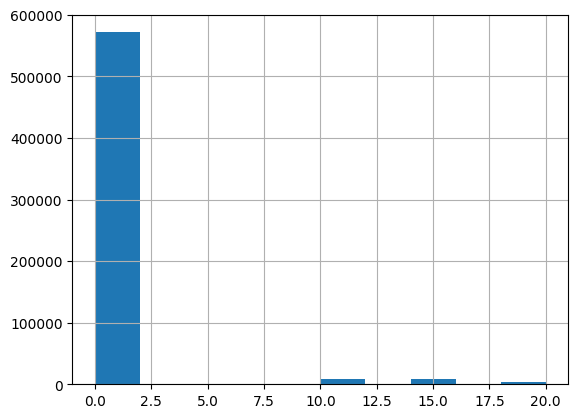

In [40]:
order_detail_sorted['CouponDiscountPct'].hist()

### Compras con cupones/ compras totales

#### Distribución de pedidos por pdv

In [41]:
##### 50 PDVs con más pedidos
top_pdvs = order_detail_sorted['PointOfSaleId'].value_counts().nlargest(50).index.tolist()


In [42]:
top_pdvs

['CLI0048689',
 'CLI0024519',
 'CLI0043030',
 '04463',
 '08431',
 'CLI0031619',
 '07015',
 'CLI0026035',
 'CLI0029791',
 'CLI0028525',
 'CLI0030422',
 '06518',
 'CLI0024798',
 'CLI0027123',
 '02961',
 '06502',
 '05814',
 '07861',
 '05883',
 'CLI0030547',
 '01998',
 '03229',
 'CLI0026553',
 '08178',
 '06643',
 'CLI0027871',
 '11519',
 'CLI0025894',
 '07413',
 'CLI0029755',
 'CLI0026028',
 '08457',
 '08016',
 '03570',
 'CLI0026980',
 '01554',
 'CLI0025624',
 '08023',
 '07617',
 '11411',
 '08201',
 'CLI0029704',
 '07985',
 'CLI0029196',
 '11058',
 'CLI0032129',
 '00376',
 '10085',
 '03320',
 'CLI0030776']

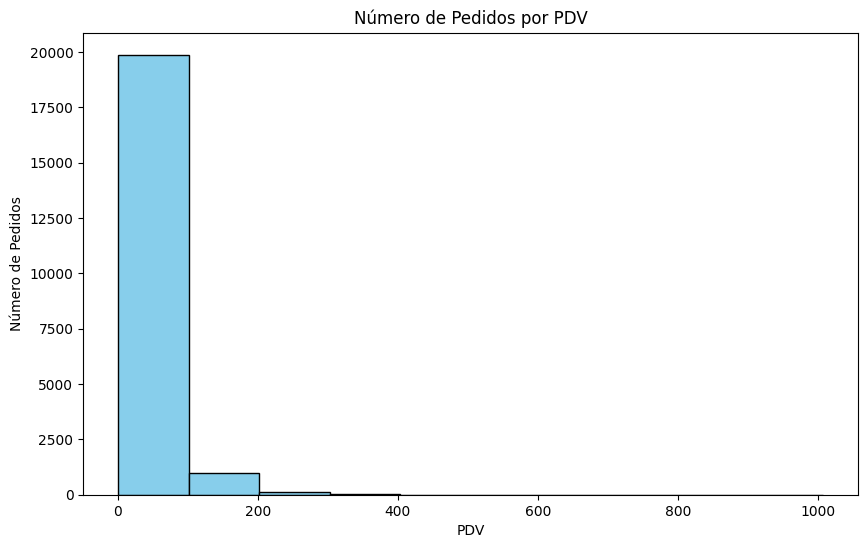

In [43]:
import matplotlib.pyplot as plt

pedidos_por_pdv = order_detail_sorted.groupby('PointOfSaleId')['Code'].count()

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(pedidos_por_pdv, bins=10, color='skyblue', edgecolor='black')
plt.title('Número de Pedidos por PDV')
plt.xlabel('PDV')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=0)
plt.show()


#### Pedidos con cupon y sin cupón por pdv

In [63]:
pedidos_con_cupon = order_detail_sorted[order_detail_sorted['HasCoupon']==1]
pedidos_sin_cupon = order_detail_sorted[order_detail_sorted['HasCoupon']==0]

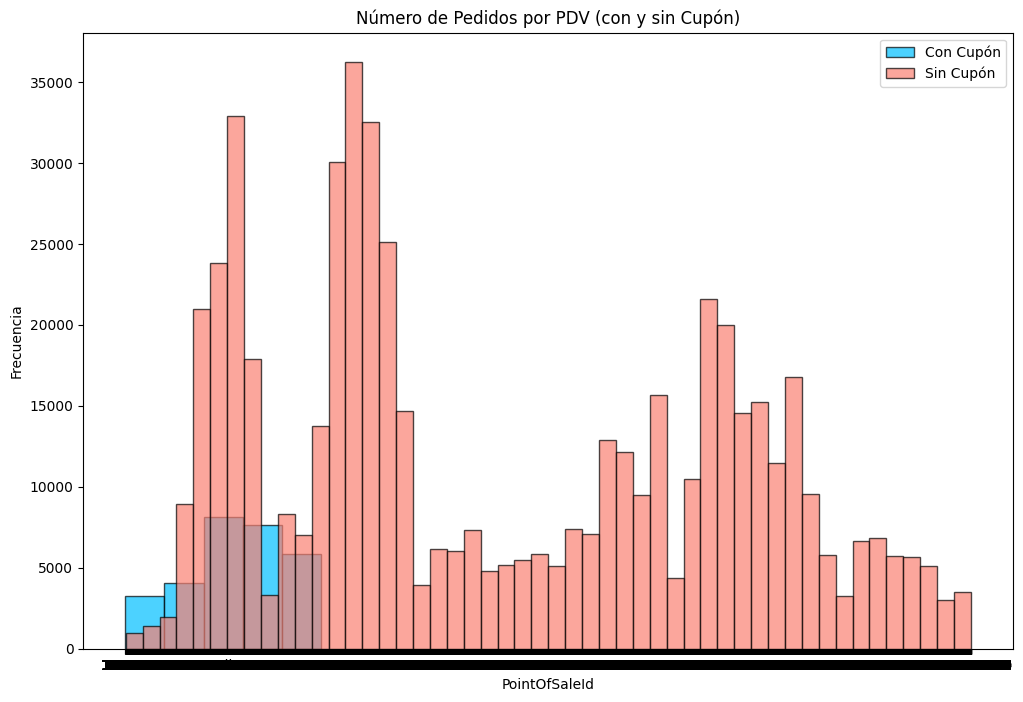

In [69]:
import matplotlib.pyplot as plt



# Crear una figura para el histograma
plt.figure(figsize=(12, 8))

# Histograma de pedidos con cupón
plt.hist(pedidos_con_cupon['PointOfSaleId'], bins=5, color='deepskyblue', edgecolor='black', alpha=0.7, label='Con Cupón')

# Histograma de pedidos sin cupón
plt.hist(pedidos_sin_cupon['PointOfSaleId'], bins=50, color='salmon', edgecolor='black', alpha=0.7, label='Sin Cupón')

# Añadir título y etiquetas
plt.title('Número de Pedidos por PDV (con y sin Cupón)')
plt.xlabel('PointOfSaleId')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.legend()

# Mostrar el gráfico
plt.show()

#### fILTRO ONLINE

#### Porcentaje de uso de cupones por rangos

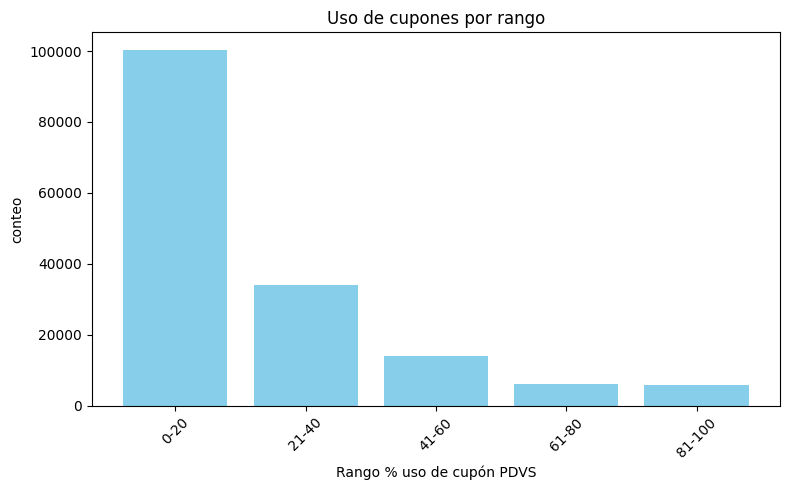

In [48]:

import matplotlib.pyplot as plt
rangos = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']

# Crear la columna con los rangos
order_detail_sorted['pctg_coupon_range'] = pd.cut(order_detail_sorted['PctgCouponUsed'], bins=rangos, labels=labels)
# Contar las ocurrencias en cada rango y ordenar por índice
range_counts = order_detail_sorted['pctg_coupon_range'].value_counts().sort_index()

# Convertir los conteos a un array de numpy
counts = range_counts.values

# # Aplicar logaritmo a los valores
# counts_log = np.log(counts)

# Plotear los datos transformados
plt.figure(figsize=(8, 5))
plt.bar(labels, counts,color='skyblue')
plt.xlabel('Rango % uso de cupón PDVS')
plt.ylabel('conteo')
plt.title('Uso de cupones por rango')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [49]:
sales_summary = order_detail_sorted.groupby('pctg_coupon_range')['Sellout'].agg(['mean', 'std', 'count']).reset_index()
sales_summary

C:\Users\ctrujils\AppData\Local\Temp\ipykernel_23228\871113514.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_summary = order_detail_sorted.groupby('pctg_coupon_range')['Sellout'].agg(['mean', 'std', 'count']).reset_index()


,pctg_coupon_range,mean,std,count
0,0-20,315.193236,411.726708,100272
1,21-40,266.238149,276.998343,33901
2,41-60,266.232088,280.758440,13972
3,61-80,252.473436,208.309861,6216
4,81-100,272.711303,221.809624,5930


c:\Users\ctrujils\Documents\Proyectos\MSM\validador\ml-validator\b2b_env\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


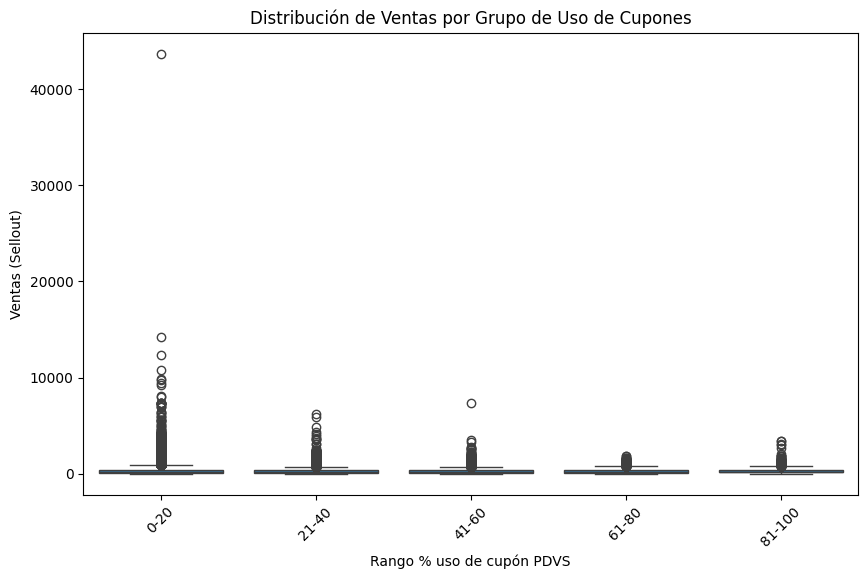

Resultado ANOVA: F=177.7052506487106, p=3.455100634836357e-152


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind

# Visualización de las ventas por grupo de uso de cupones
plt.figure(figsize=(10, 6))
sns.boxplot(x='pctg_coupon_range', y='Sellout', data=order_detail_sorted)
plt.title('Distribución de Ventas por Grupo de Uso de Cupones')
plt.xlabel('Rango % uso de cupón PDVS')
plt.ylabel('Ventas (Sellout)')
plt.xticks(rotation=45)
plt.show()

# Comparación de medias (ANOVA)
groups = [order_detail_sorted[order_detail_sorted['pctg_coupon_range'] == label]['Sellout'] for label in labels]
anova_result = f_oneway(*groups)
print(f'Resultado ANOVA: F={anova_result.statistic}, p={anova_result.pvalue}')

#### Estacionalidad en el uso de cupones

In [0]:
order_detail_sorted['year']=order_detail_sorted['OrderDate'].dt.year

In [0]:
order_detail_sorted['month']=order_detail_sorted['OrderDate'].dt.month


In [0]:
order_detail_sorted_2023=order_detail_sorted[order_detail_sorted['year']==2023]

In [0]:
compras_por_mes=order_detail_sorted_2023['month'].value_counts().sort_index()

In [0]:
pedidos_con_cupon = order_detail_sorted_2023[order_detail_sorted_2023['CouponDescription']!= 'NoCupon']['month'].value_counts().sort_index()

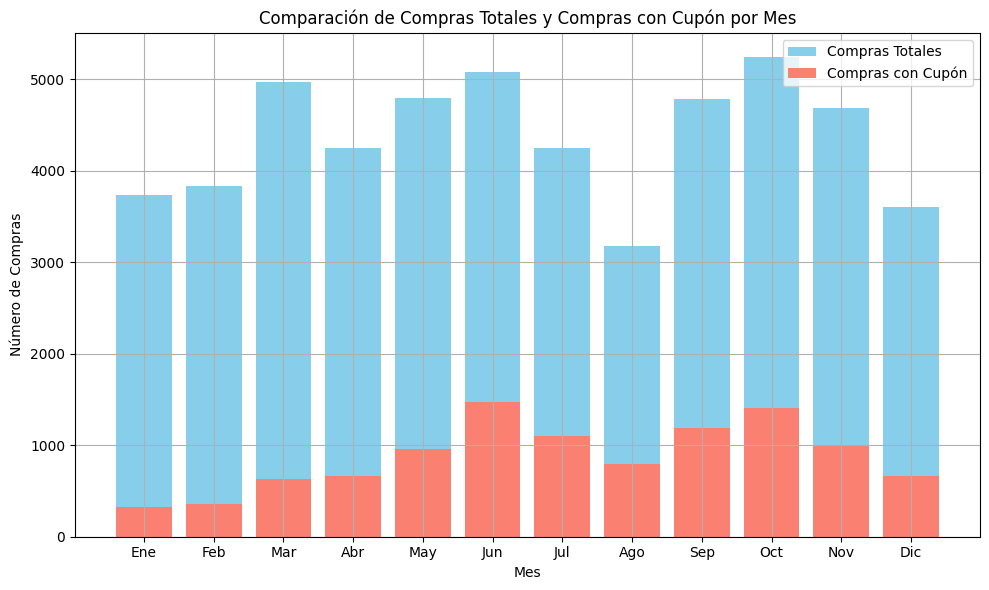

In [0]:
compras_por_mes = dict(sorted(compras_por_mes.items()))
pedidos_con_cupon = dict(sorted(pedidos_con_cupon.items()))

# Obtener los meses y las cantidades ordenadas
meses = np.arange(1, 13)
cantidades_compras = [compras_por_mes.get(mes, 0) for mes in meses]
cantidades_cupon = [pedidos_con_cupon.get(mes, 0) for mes in meses]

plt.figure(figsize=(10, 6))

# Gráfico de barras para las compras totales por mes
plt.bar(meses, cantidades_compras, color='skyblue', label='Compras Totales')

# Gráfico de barras para los pedidos con cupón por mes
plt.bar(meses, cantidades_cupon, color='salmon', label='Compras con Cupón')

# Configuración de ejes y etiquetas
plt.xlabel('Mes')
plt.ylabel('Número de Compras')
plt.title('Comparación de Compras Totales y Compras con Cupón por Mes')
plt.xticks(np.arange(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

#### Sellout tipologia de punto de venta

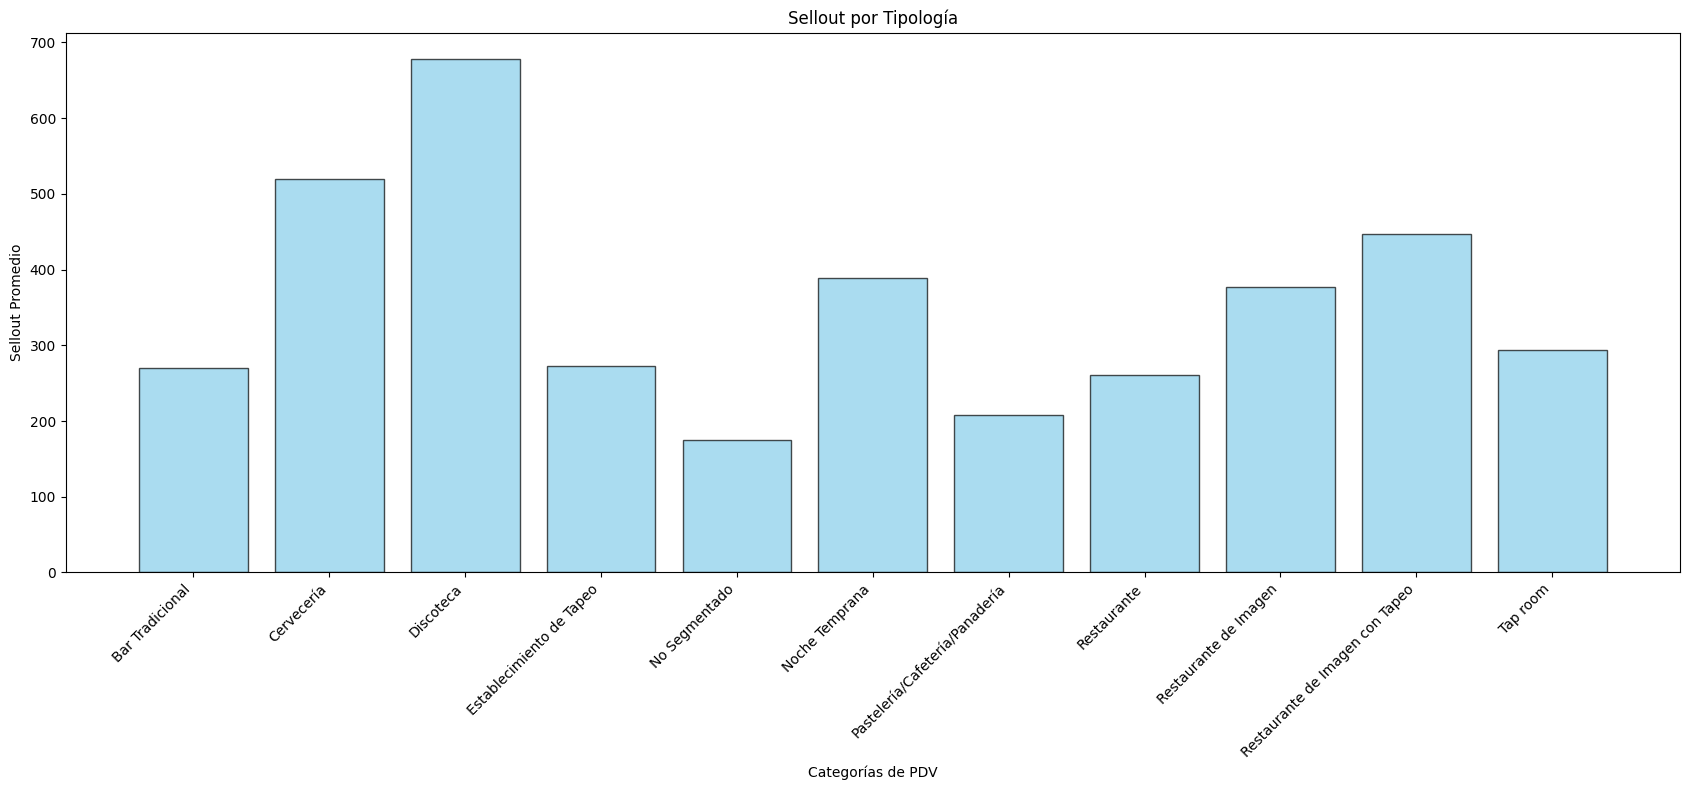

In [51]:
import matplotlib.pyplot as plt

# Suponiendo que sellout_tipologia tiene dos columnas: 'tipologia' y 'TotalPrice'
sellout_tipologia = order_detail_sorted.groupby('tipologia')['Sellout'].mean().reset_index()

# Crear figura y ejes
plt.figure(figsize=(17, 8))

# Gráfico de barras para el sellout por tipología
plt.bar(sellout_tipologia['tipologia'], sellout_tipologia['Sellout'], color='skyblue', edgecolor='black', alpha=0.7)

# Configuración de ejes y etiquetas
plt.title('Sellout por Tipología')
plt.xlabel('Categorías de PDV')
plt.xticks(rotation=45, ha='right')

plt.ylabel('Sellout Promedio')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


#### Sellout cupon/no cupon por tipologia

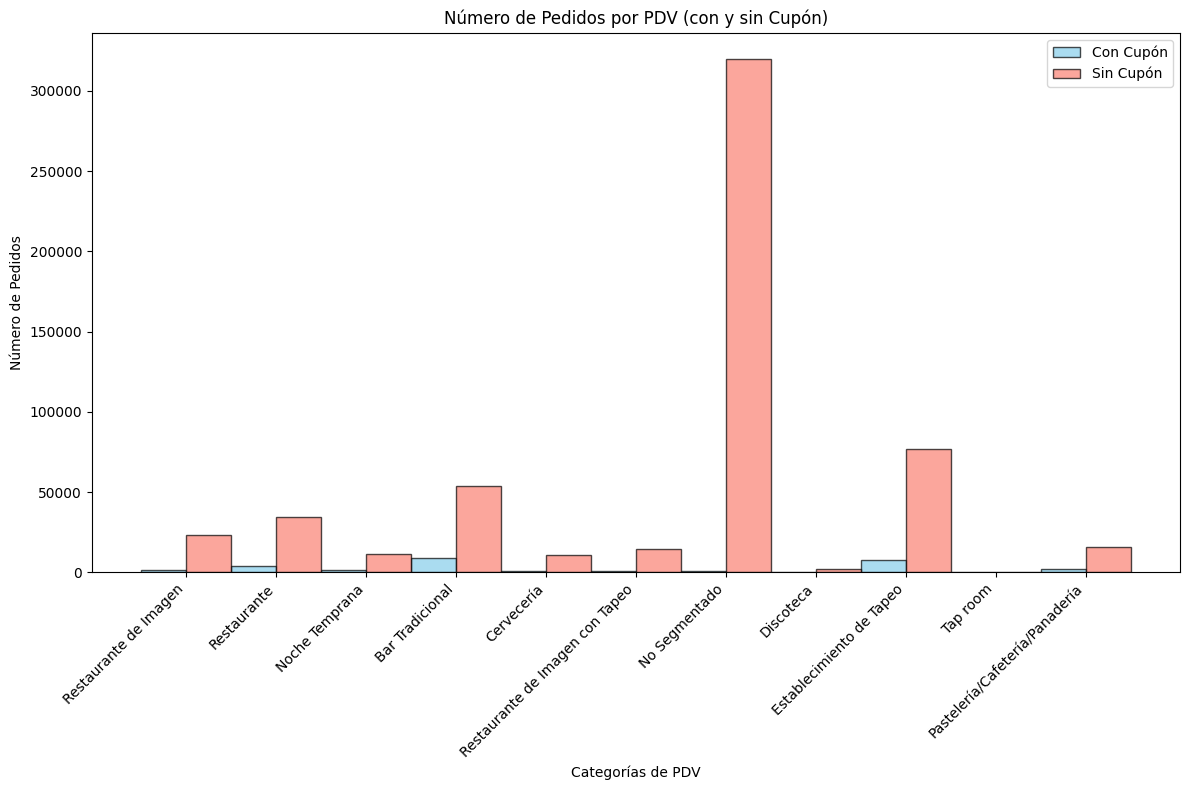

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
pedidos_con_cupon_tipologia =order_detail_sorted[order_detail_sorted['HasCoupon'] == 1] ['tipologia'].value_counts()
pedidos_sin_cupon_tipologia = order_detail_sorted[order_detail_sorted['HasCoupon'] == 0]['tipologia'].value_counts()

# Crear un DataFrame que combine ambos sets de datos
tipologias = list(set(pedidos_con_cupon_tipologia.index).union(set(pedidos_sin_cupon_tipologia.index)))
pedidos_con_cupon = [pedidos_con_cupon_tipologia.get(tipologia, 0) for tipologia in tipologias]
pedidos_sin_cupon = [pedidos_sin_cupon_tipologia.get(tipologia, 0) for tipologia in tipologias]

# Índices de las categorías
indices = np.arange(len(tipologias))

# Ancho de las barras
width = 0.50

# Crear figura
plt.figure(figsize=(12, 8))

# Gráfico de barras para los pedidos con cupón
plt.bar(indices - width/2, pedidos_con_cupon, width, color='skyblue', label='Con Cupón', edgecolor='black', alpha=0.7)

# Gráfico de barras para los pedidos sin cupón
plt.bar(indices + width/2, pedidos_sin_cupon, width, color='salmon', label='Sin Cupón', edgecolor='black', alpha=0.7)

# Configuración de ejes y etiquetas
plt.title('Número de Pedidos por PDV (con y sin Cupón)')
plt.xlabel('Categorías de PDV')
plt.ylabel('Número de Pedidos')
plt.xticks(indices, tipologias, rotation=45, ha='right')
plt.legend()

# Ajuste del diseño y muestra del gráfico
plt.tight_layout()
plt.show()


#### Sellout por tipologia de cupon

In [55]:
sellout_promedio_por_cupon

Coupon_type
Fijo          337.448869
NoCupon       230.870983
Porcentual    303.970800
Name: Sellout, dtype: float64

In [57]:
sellout_origen

Origin
OFFLINE    229.846088
Online     301.171271
Name: Sellout, dtype: float64

### Compras por season

In [58]:
order_detail_sorted['season'].value_counts()

KeyError: 'season'

In [0]:
seasonal_sellout = order_detail_sorted.groupby('season')['Sellout'].sum()


In [0]:
seasonal_sellout.sort_values(ascending=False)

season
Primavera    1.049369e+07
Invierno     7.301582e+06
Verano       6.658724e+06
Otoño        6.113670e+06
Name: Sellout, dtype: float64